<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day02(DataForensics).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Most people just do df.fillna(df.mean()) and move on. This is often wrong and can seriously bias your models. The correct imputation strategy depends on why the data is missing:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression

plt.style.use('seaborn-v0_8-whitegrid')
print('Setup Complete!')

Setup Complete!


Part 1: Understanding Missing Data Mechanisms

MCAR - Missing Completely At Random.(can use mean imputation)

MAR	Missing At Random (depends on OTHER columns)

MNAR	Missing Not At Random (depends on the VALUE itself)


In [7]:
def create_missing_data_demo(n=1000, seed=42):
  rng = np.random.default_rng(seed)

  df = pd.DataFrame({
      'age': rng.normal(40, 12, n),
      'income': rng.lognormal(10.5, 0.5, n),
      'education_years': rng.normal(12, 2, n)
  })

  df_complete = df.copy()

  # 1. MCAR: Random 10% missing in 'age'
  mcar_mask = rng.random(n)< 0.10
  df.loc[mcar_mask, 'age'] = np.nan

  # 2. MAR: Income missing depends on education (less educated -> more missing)
  mar_prob = np.where(df_complete['education_years'] < 12, 0.30, 0.05)
  mar_mask = rng.random(n) < mar_prob
  df.loc[mar_mask, 'income'] = np.nan

  # 3. MNAR: High income people hide their income (high income -> more missing)
  mnar_prob = np.where(df_complete['income'] > 50000, 0.40, 0.05)
  mnar_mask = rng.random(n) < mnar_prob
  df['income_mnar'] = df_complete['income'].copy()
  df.loc[mnar_mask, 'income_mnar'] = np.nan

  return df, df_complete

df, df_complete = create_missing_data_demo()

print("Missing values created:")
print(f"  age (MCAR):  {df['age'].isna().sum():3d} ({df['age'].isna().mean()*100:.1f}%)")
print(f"  income (MAR):  {df['income'].isna().sum():3d} ({df['income'].isna().mean()*100:.1f}%)")
print(f"  income_mnar (MNAR): {df['income_mnar'].isna().sum():3d}({df['income_mnar'].isna().mean()*100:.1f}%)")

Missing values created:
  age (MCAR):  107 (10.7%)
  income (MAR):  183 (18.3%)
  income_mnar (MNAR): 147(14.7%)


Visualizing Missing data

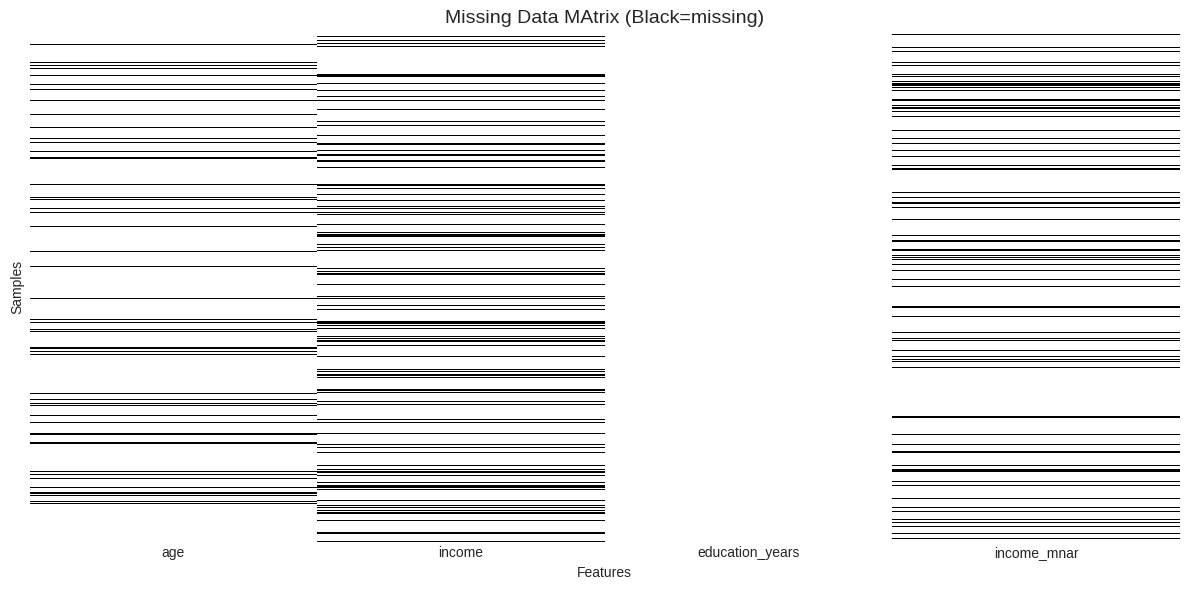

In [8]:
def plot_missing_matrix(df, figsize=(12, 6)):
  fig, ax = plt.subplots(figsize=figsize)
  sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='binary', ax=ax)
  ax.set_title("Missing Data MAtrix (Black=missing)", fontsize=14)
  ax.set_xlabel("Features")
  ax.set_ylabel("Samples")
  plt.tight_layout()
  return fig
plot_missing_matrix(df)
plt.show()


In [12]:
def plot_missing_by_other_column(df, missing_col, compare_col, df_complete=None):
    """
    Compare the distribution of compare_col for rows where missing_col is missing vs present.

    This is the KEY visualization for detecting MAR!
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    missing_mask = df[missing_col].isnull()

    # Left: Distribution of compare_col split by missingness
    ax = axes[0]
    present_vals = df.loc[~missing_mask, compare_col].dropna()
    missing_vals = df.loc[missing_mask, compare_col].dropna()

    ax.hist(present_vals, bins=30, alpha=0.5, label=f'{missing_col} Present', density=True)
    ax.hist(missing_vals, bins=30, alpha=0.5, label=f'{missing_col} Missing', density=True)
    ax.set_xlabel(compare_col)
    ax.set_ylabel('Density')
    ax.legend()

    # KS test
    ks_stat, p_value = stats.ks_2samp(present_vals, missing_vals)
    ax.set_title(f'{compare_col} distribution by {missing_col} missingness\n'
                f'KS test p-value: {p_value:.4f} {"(significant!)" if p_value < 0.05 else ""}')

    # Right: If we have complete data, show what's being hidden
    ax = axes[1]
    if df_complete is not None:
        true_present = df_complete.loc[~missing_mask, missing_col]
        true_missing = df_complete.loc[missing_mask, missing_col]

        ax.hist(true_present, bins=30, alpha=0.5, label='Observed values', density=True)
        ax.hist(true_missing, bins=30, alpha=0.5, label='Hidden (missing) values', density=True)
        ax.set_xlabel(missing_col)
        ax.set_ylabel('Density')
        ax.legend()
        ax.set_title(f'What\'s actually being hidden in {missing_col}?')

    plt.tight_layout()
    return fig


Checking MAR: Does income missingness depend on education?


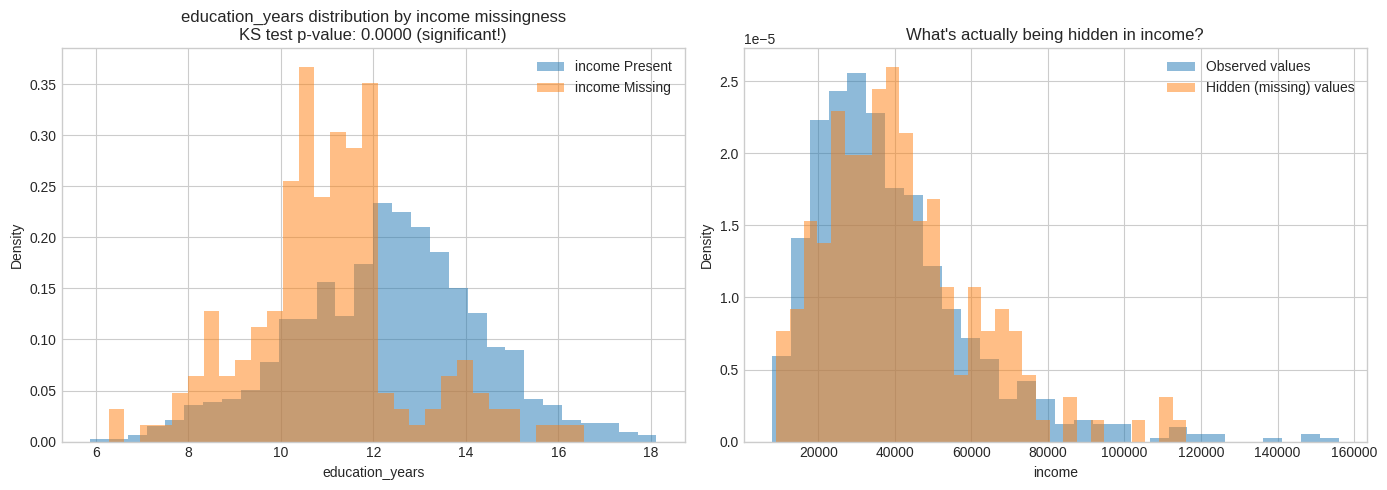

In [14]:
#check if income missingness depends on education (MAR Test)
print("Checking MAR: Does income missingness depend on education?")
plot_missing_by_other_column(df, 'income', 'education_years', df_complete)
plt.show()

Checking MCAR: Does age missingness depend on education?


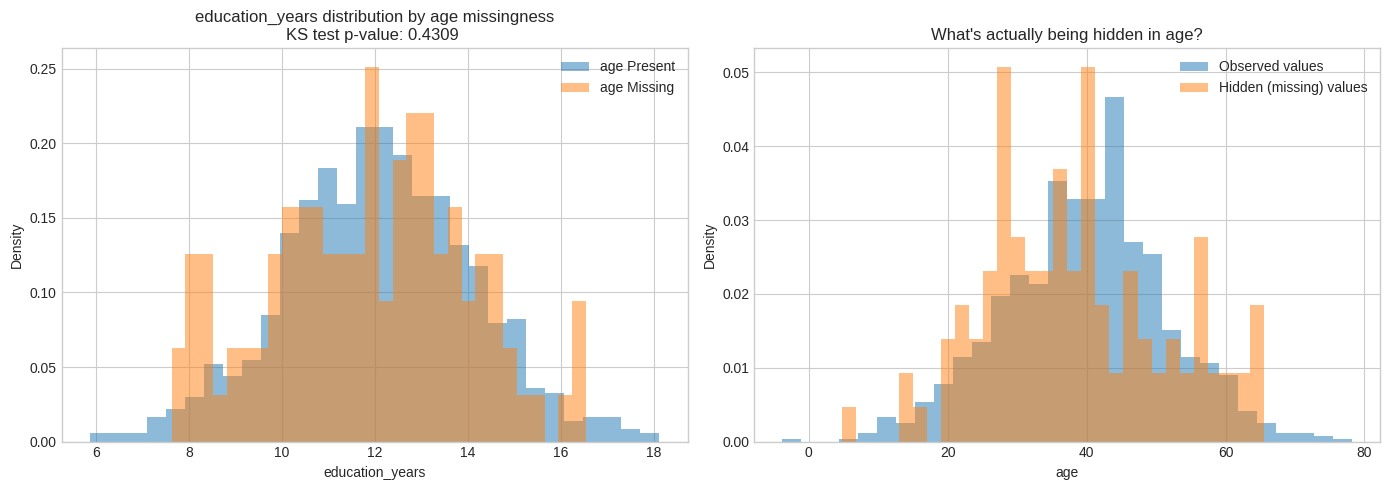

In [15]:
# Check MCAR: Does age missingness depend on education?
print("Checking MCAR: Does age missingness depend on education?")
plot_missing_by_other_column(df, 'age', 'education_years', df_complete)
plt.show()

# Notice: Distributions are similar! This is MCAR.

Checking MNAR: What income values are being hidden?


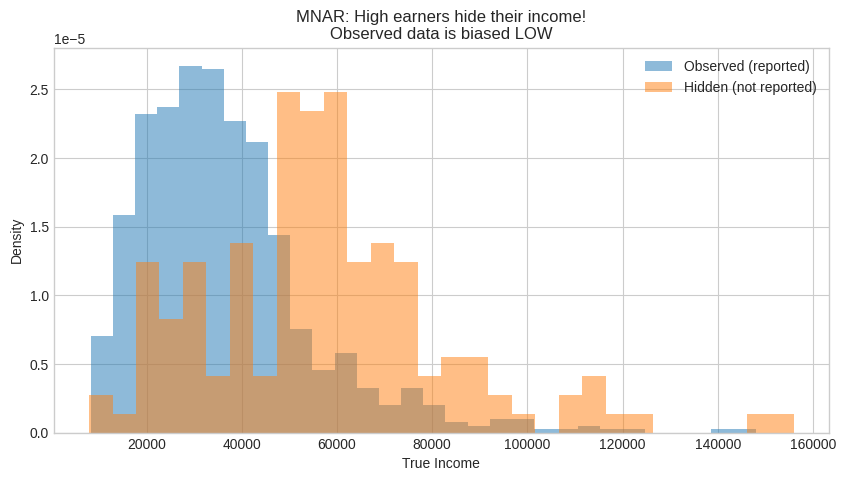

In [16]:
# Check MNAR: Look at what's being hidden
print("Checking MNAR: What income values are being hidden?")

fig, ax = plt.subplots(figsize=(10, 5))
missing_mask = df['income_mnar'].isnull()

# Show the TRUE values that are being hidden
ax.hist(df_complete.loc[~missing_mask, 'income'], bins=30, alpha=0.5,
        label='Observed (reported)', density=True)
ax.hist(df_complete.loc[missing_mask, 'income'], bins=30, alpha=0.5,
        label='Hidden (not reported)', density=True)
ax.set_xlabel('True Income')
ax.set_ylabel('Density')
ax.legend()
ax.set_title('MNAR: High earners hide their income!\nObserved data is biased LOW')
plt.show()


## Detecting Missing Mechanisms Statistically

Test 1: MAR detection using Log Regression

In [21]:
def test_mar(df, target_col,  predictor_cols):
  # Target: 1 if missing, 0 if present
  y = df[target_col].isnull().astype(int)

  #Predictors
  X = df[predictor_cols].dropna()
  y = y[X.index]

  # Standardize
  X = (X - X.mean()) / X.std()

  #Fit logistic regression
  model = LogisticRegression()
  model.fit(X, y)

  #Calculate pseudo R^2 (McFadden)
  from sklearn.metrics import log_loss
  null_prob = y.mean()
  null_ll = - log_loss(y, [null_prob]*len(y), normalize=False)
  model_ll = -log_loss(y, model.predict_proba(X)[:, 1], normalize=False)
  pseudo_r2 = 1 - (model_ll / null_ll) if null_ll != 0 else 0

  #Coefficients
  coefs = pd.Series(model.coef_[0], index=predictor_cols)

  return {
      'pseudo_r2': pseudo_r2,
      'coefficients': coefs,
      'interpretation': 'Strong MAR' if pseudo_r2 > 0.1 else
                        'some MAR' if pseudo_r2 > 0.02 else
                        'No MAR'
  }


In [22]:
#Test each columnn
predictors = ['education_years']

print("MAR test results:")
print('=' * 60)

for col in ['age', 'income', 'income_mnar']:
    result = test_mar(df, col, predictors)
    print(f"\n{col}:")
    print(f"  Pseudo R²: {result['pseudo_r2']:.4f}")
    print(f"  Interpretation: {result['interpretation']}")
    print(f"  Coefficients: {result['coefficients'].to_dict()}")

MAR test results:

age:
  Pseudo R²: 0.0013
  Interpretation: No MAR
  Coefficients: {'education_years': -0.09533916900768498}

income:
  Pseudo R²: 0.0697
  Interpretation: some MAR
  Coefficients: {'education_years': -0.6957106339776845}

income_mnar:
  Pseudo R²: 0.0004
  Interpretation: No MAR
  Coefficients: {'education_years': 0.04960468000903096}


Key insight:

age (MCAR): Can't predict missingness → low R²

income (MAR): CAN predict from education → high R²

income_mnar (MNAR): Can't predict from other columns (because it depends on ITSELF)

Imputation Strategies

In [25]:
rng = np.random.default_rng(42)
n = 500

#correlated features
age = rng.normal(40, 10, n)
income = 10000 + 1000 * age + rng.normal(0, 10000, n)

df_demo = pd.DataFrame({'age': age, 'income': income})
df_demo_complete =df_demo.copy()

mar_prob = np.where(df_demo['age'] < 35, 0.4, 0.05)
mar_mask = rng.random(n) < mar_prob
df_demo.loc[mar_mask, 'income'] = np.nan

print(f"Missing: {df_demo['income'].isna().sum()} ({df_demo['income'].isna().mean()*100:.1f}%)")
print(f"\nTrue mean income: ${df_demo_complete['income'].mean():,.0f}")
print(f"Observed mean (biased!): ${df_demo['income'].mean():,.0f}")
#

Missing: 83 (16.6%)

True mean income: $49,422
Observed mean (biased!): $51,425


In [28]:
# Strategy 1: Mean Imputation
df_mean = df_demo.copy()
df_mean['income'].fillna(df_mean['income'].mean(), inplace=True)

# Strategy 2: Median Imputation
df_median = df_demo.copy()
df_median['income'].fillna(df_median['income'].median(), inplace=True)

# Strategy 3: KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5)
df_knn = pd.DataFrame(
    imputer_knn.fit_transform(df_demo),
    columns=df_demo.columns
)

# Strategy 4: Iterative (MICE-like) Imputation
imputer_iter = IterativeImputer(random_state=42, max_iter=10)
df_iter = pd.DataFrame(
    imputer_iter.fit_transform(df_demo),
    columns=df_demo.columns
)


/tmp/ipython-input-2038088071.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_mean['income'].fillna(df_mean['income'].mean(), inplace=True)
/tmp/ipython-input-2038088071.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [29]:
# Compare imputation results
def evaluate_imputation(df_imputed, df_complete, df_missing, col):
    """Calculate error metrics for imputation."""
    missing_mask = df_missing[col].isnull()

    true_vals = df_complete.loc[missing_mask, col]
    imputed_vals = df_imputed.loc[missing_mask, col]

    rmse = np.sqrt(((imputed_vals - true_vals) ** 2).mean())
    mae = np.abs(imputed_vals - true_vals).mean()
    bias = (imputed_vals - true_vals).mean()

    return {'rmse': rmse, 'mae': mae, 'bias': bias}

results = {
    'Mean': evaluate_imputation(df_mean, df_demo_complete, df_demo, 'income'),
    'Median': evaluate_imputation(df_median, df_demo_complete, df_demo, 'income'),
    'KNN': evaluate_imputation(df_knn, df_demo_complete, df_demo, 'income'),
    'Iterative': evaluate_imputation(df_iter, df_demo_complete, df_demo, 'income'),
}

print("Imputation Comparison (lower is better):")
print("=" * 60)
print(f"{'Method':<12} {'RMSE':>12} {'MAE':>12} {'Bias':>12}")
print("-" * 60)
for method, metrics in results.items():
    print(f"{method:<12} {metrics['rmse']:>12,.0f} {metrics['mae']:>12,.0f} {metrics['bias']:>12,.0f}")

Imputation Comparison (lower is better):
Method               RMSE          MAE         Bias
------------------------------------------------------------
Mean               17,848       14,934       12,068
Median             18,321       15,456       12,756
KNN                12,245        9,661        2,884
Iterative          11,052        8,712        2,676


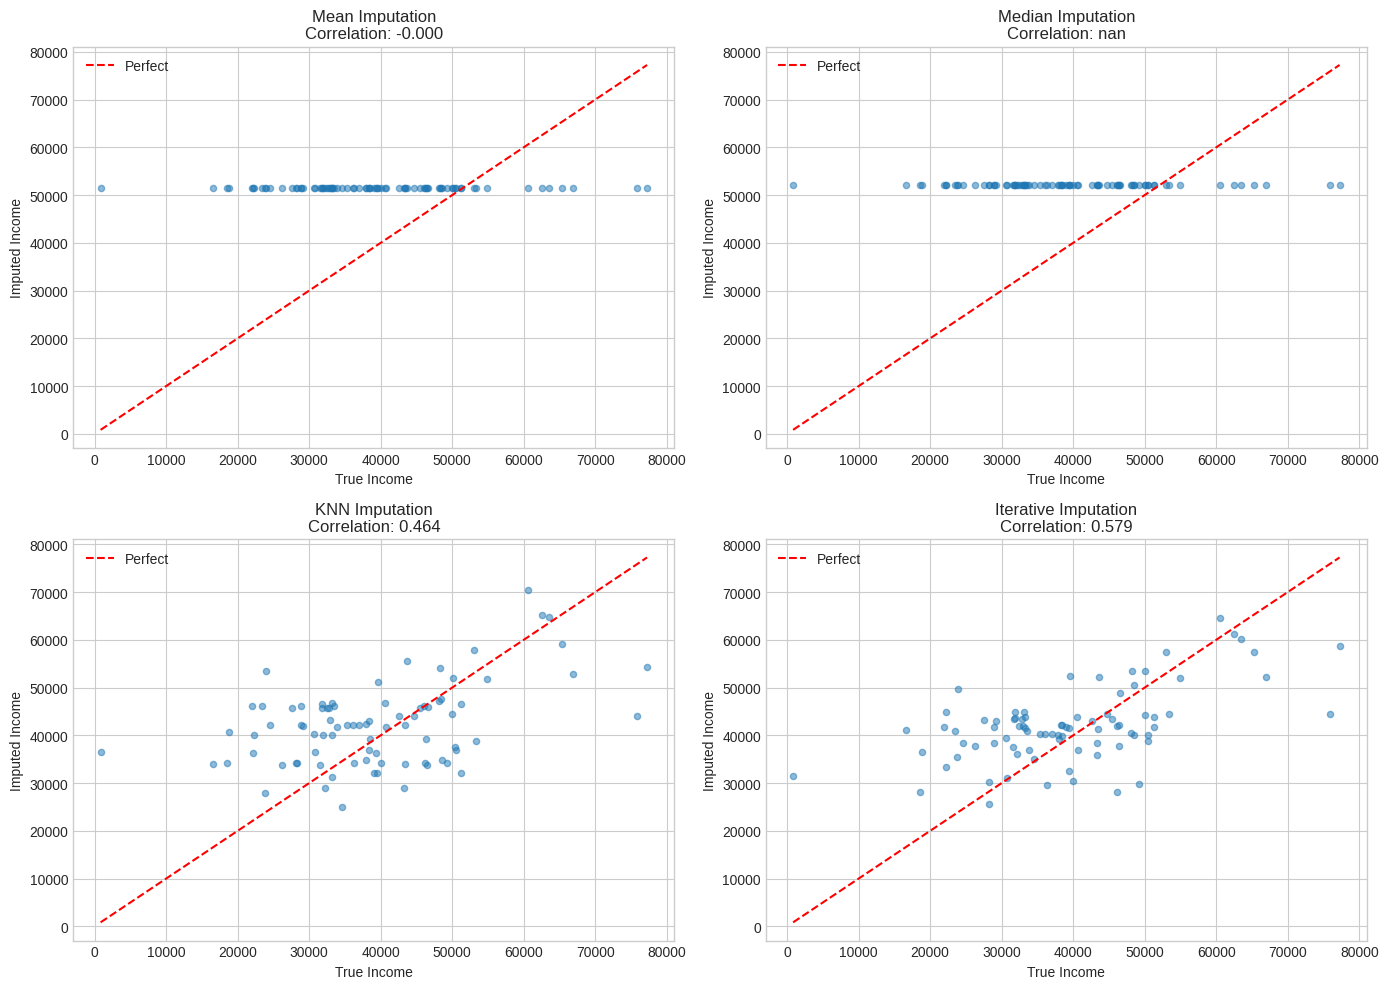

In [31]:
# Visualize imputation quality
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

methods = [
    ('Mean Imputation', df_mean),
    ('Median Imputation', df_median),
    ('KNN Imputation', df_knn),
    ('Iterative Imputation', df_iter)
]

missing_mask = df_demo['income'].isnull()

for ax, (name, df_imp) in zip(axes.flat, methods):
    # True vs imputed for missing values only
    true_vals = df_demo_complete.loc[missing_mask, 'income']
    imputed_vals = df_imp.loc[missing_mask, 'income']

    ax.scatter(true_vals, imputed_vals, alpha=0.5, s=20)

    # Perfect line
    min_val = min(true_vals.min(), imputed_vals.min())
    max_val = max(true_vals.max(), imputed_vals.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect')

    # Calculate R²
    correlation = np.corrcoef(true_vals, imputed_vals)[0, 1]

    ax.set_xlabel('True Income')
    ax.set_ylabel('Imputed Income')
    ax.set_title(f'{name}\nCorrelation: {correlation:.3f}')
    ax.legend()

plt.tight_layout()
plt.show()

In [32]:
def impute_with_indicator(df, col):
    """
    Impute with mean + add missing indicator.
    Useful when missingness itself is predictive (MNAR hint).
    """
    df_result = df.copy()

    # Add indicator BEFORE imputing
    df_result[f'{col}_was_missing'] = df_result[col].isnull().astype(int)

    # Then impute
    df_result[col].fillna(df_result[col].mean(), inplace=True)

    return df_result

# Example with MNAR data
df_indicator = impute_with_indicator(df[['income_mnar', 'education_years']].copy(), 'income_mnar')
print(df_indicator.head(10))
print(f"\nNew column added: income_mnar_was_missing")

    income_mnar  education_years  income_mnar_was_missing
0  35254.860208        11.096098                        0
1  25219.090137        10.668245                        0
2  29518.234413        12.868020                        0
3  49859.044282        12.503709                        0
4  36369.894804         9.190417                        0
5  43049.460956        14.245357                        0
6  36496.028913        11.811611                        1
7  30108.995760         9.778138                        0
8  53004.075289        14.377568                        0
9  43889.101100        13.251351                        0

New column added: income_mnar_was_missing


/tmp/ipython-input-2205172303.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_result[col].fillna(df_result[col].mean(), inplace=True)


---
## Part 6: Decision Framework

Here's your practical guide for handling missing data:

```
1. VISUALIZE the missing data pattern
   └── plot_missing_matrix()
   └── plot_missing_by_other_column()

2. TEST for mechanism
   └── Can you predict missingness from other columns?
       ├── YES (high R²) → MAR
       └── NO (low R²) → MCAR or MNAR
   └── Do observed values look different from complete population?
       ├── YES → Likely MNAR
       └── NO → Likely MCAR

3. CHOOSE imputation strategy
   ├── MCAR → Mean/Median OK
   ├── MAR → KNN or Iterative (MICE)
   └── MNAR → Add missing indicator + domain knowledge

4. VALIDATE (if possible)
   └── Use synthetic data to test your approach
```

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import os
path = '/content/drive/MyDrive/100-days-of-ml/phase-1-data-foundations/day-02-missing-data-forensics'
os.makedirs(path, exist_ok=True)
print(f'Created: {path}')

Created: /content/drive/MyDrive/100-days-of-ml/phase-1-data-foundations/day-02-missing-data-forensics
